In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_massver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'train_mass_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_massver', 'train_mass_FN.npy'))
    return images, labels#, FN


def load_testing():
    images = np.load(os.path.join('../Data_final_massver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_massver', 'test_mass_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_massver', 'test_mass_FN.npy'))
    return images, labels#, FN

In [3]:
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 1390 	 Test size: 306
Image size: 256x256


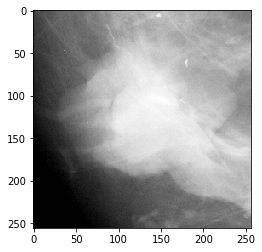

Label: 1


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
#print("FN: " + str(test_FN[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(1390, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_vgg16(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(output, activation='softmax'))

    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [11]:
vgg = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in vgg.layers:
    layer.trainable = False
vgg_maxpool = vgg.get_layer('block5_pool').output
FeatureFlatten = Flatten()(vgg_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_vgg = Model(inputs = vgg.input, outputs = predictions)
new_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [13]:
vgg16_mass_benign_or_malignant_best_Adam = new_vgg

In [12]:
vgg16_mass_benign_or_malignant_best_RMSprop = new_vgg

In [22]:
vgg16_mass_benign_or_malignant_best_Adam = create_vgg16(dropout=0.5, fc_size=128, output = 2)

In [23]:
vgg16_mass_benign_or_malignant_best_Adam.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 33,686,914
Non-trainable params: 14,714,688
___________________________________

### Adam

In [14]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [15]:
# Train
history_vgg16_mass_benign_or_malignant_best_Adam = vgg16_mass_benign_or_malignant_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 2.6177 - recall: 0.5039
Epoch 00001: val_loss improved from inf to 0.71731, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 14s 3s/step - loss: 2.4092 - recall: 0.4922 - val_loss: 0.7173 - val_recall: 0.6151
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9284 - recall: 0.5996
Epoch 00002: val_loss did not improve from 0.71731
5/5 [==============================] - 10s 2s/step - loss: 0.8693 - recall: 0.6187 - val_loss: 0.8650 - val_recall: 0.5827
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8771 - recall: 0.5085
Epoch 00003: val_loss did not improve from 0.71731
5/5 [==============================] - 11s 2s/step - loss: 0.8423 - recall: 0.5183 - val_los

In [16]:
models.save_model(vgg16_mass_benign_or_malignant_best_Adam, '../model/vgg16_mass_benign_or_malignant_end_Adam.h5')

In [17]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adam.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adam.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adam.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adam.history['val_recall']

In [18]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Adam.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

In [19]:
print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 55
Epoch [opt]: 25
Valid accuracy [end]: 0.6835
Valid accuracy [opt]: 0.7014
Test accuracy [end]:  0.6536
Test accuracy [opt]:  0.6307
Valid loss [end]: 0.5438
Valid loss [opt]: 0.5384
Test loss [end]:  0.6657
Test loss [opt]:  0.6762


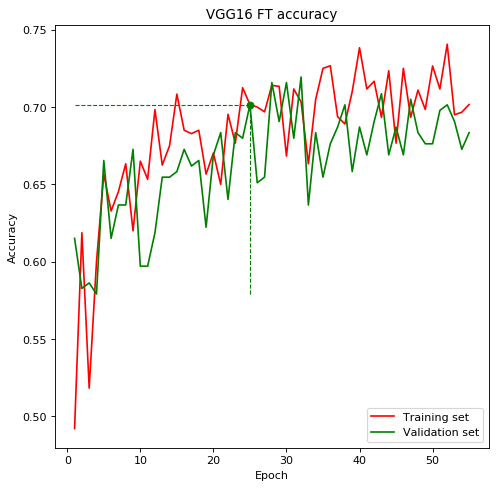

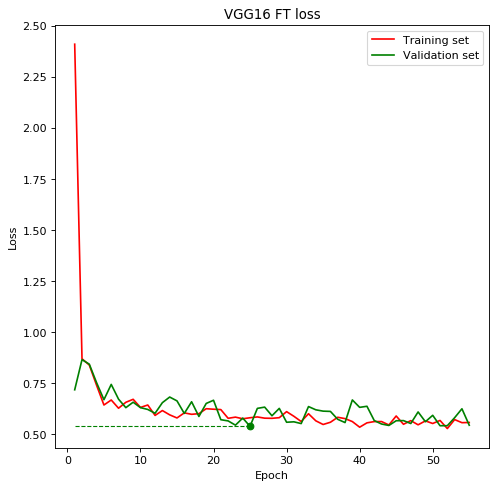

In [20]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [26]:
vgg16_mass_benign_or_malignant_best_SGD = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [27]:
# Train
history_vgg16_mass_benign_or_malignant_best_SGD = vgg16_mass_benign_or_malignant_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3078 - recall: 0.5148
Epoch 00001: val_loss improved from inf to 1.03460, saving model to ../model/vgg16_mass_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 10s 2s/step - loss: 1.2552 - recall: 0.5200 - val_loss: 1.0346 - val_recall: 0.4784
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1428 - recall: 0.5391
Epoch 00002: val_loss did not improve from 1.03460
5/5 [==============================] - 10s 2s/step - loss: 1.1316 - recall: 0.5344 - val_loss: 1.2162 - val_recall: 0.4964
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0355 - recall: 0.4883
Epoch 00003: val_loss improved from 1.03460 to 0.86368, saving model to ../model/vgg16_mass_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 12s 2s/step - loss: 1.0611 - recall: 0.5031 - val_loss: 0

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0700 - recall: 0.5191
Epoch 00030: val_loss did not improve from 0.66939
5/5 [==============================] - 10s 2s/step - loss: 1.0491 - recall: 0.5267 - val_loss: 0.7076 - val_recall: 0.5827
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0129 - recall: 0.5381
Epoch 00031: val_loss did not improve from 0.66939
5/5 [==============================] - 10s 2s/step - loss: 0.9932 - recall: 0.5483 - val_loss: 0.7624 - val_recall: 0.5396
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9546 - recall: 0.5371
Epoch 00032: val_loss did not improve from 0.66939
5/5 [==============================] - 10s 2s/step - loss: 0.9554 - recall: 0.5578 - val_loss: 0.6959 - val_recall: 0.6079
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8832 - recall: 0.5742
Epoch 00033: val_loss did not improve from 0.66939
5/5 [==============================] - 10s 2s/step - loss: 

In [28]:
models.save_model(vgg16_mass_benign_or_malignant_best_SGD, '../model/vgg16_mass_benign_or_malignant_end_SGD.h5')

In [29]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_SGD.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_SGD.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_SGD.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_SGD.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 84
Epoch [opt]: 54
Valid accuracy [end]: 0.5935
Valid accuracy [opt]: 0.6151
Test accuracy [end]:  0.5392
Test accuracy [opt]:  0.5261
Valid loss [end]: 0.7132
Valid loss [opt]: 0.6242
Test loss [end]:  0.8128
Test loss [opt]:  0.8600


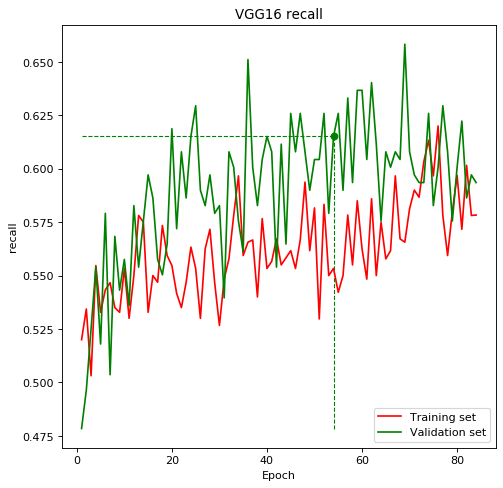

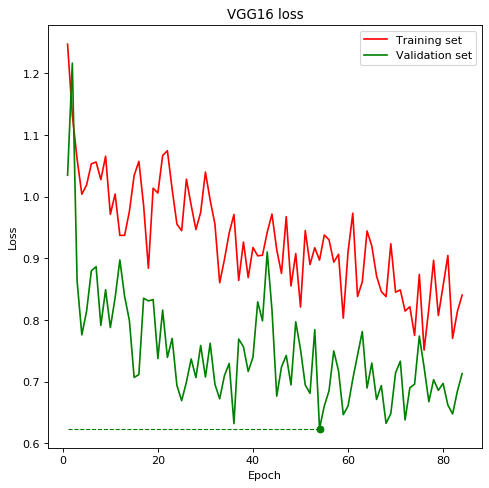

In [30]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [13]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg16_mass_benign_or_malignant_best_RMSprop = vgg16_mass_benign_or_malignant_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 3s - loss: 3.8284 - recall: 0.4915
Epoch 00001: val_loss improved from inf to 0.70789, saving model to ../model/vgg16_mass_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 17s 3s/step - loss: 3.2193 - recall: 0.5250 - val_loss: 0.7079 - val_recall: 0.5612
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7930 - recall: 0.5360
Epoch 00002: val_loss improved from 0.70789 to 0.63232, saving model to ../model/vgg16_mass_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 10s 2s/step - loss: 0.7808 - recall: 0.5483 - val_loss: 0.6323 - val_recall: 0.6151
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7137 - recall: 0.5996
Epoch 00003: val_loss did not improve from 0.63232
5/5 [=======

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6130 - recall: 0.6660
Epoch 00029: val_loss did not improve from 0.58999
5/5 [==============================] - 10s 2s/step - loss: 0.6086 - recall: 0.6781 - val_loss: 0.6753 - val_recall: 0.6223
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6298 - recall: 0.6653
Epoch 00030: val_loss did not improve from 0.58999
5/5 [==============================] - 11s 2s/step - loss: 0.6215 - recall: 0.6583 - val_loss: 0.6189 - val_recall: 0.6079
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6489 - recall: 0.6172
Epoch 00031: val_loss did not improve from 0.58999
5/5 [==============================] - 10s 2s/step - loss: 0.6541 - recall: 0.6125 - val_loss: 0.5924 - val_recall: 0.6439
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5877 - recall: 0.7182
Epoch 00032: val_loss did not improve from 0.58999
5/5 [==============================] - 11s 2s/step - loss: 

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6040 - recall: 0.6992
Epoch 00059: val_loss did not improve from 0.56705
5/5 [==============================] - 10s 2s/step - loss: 0.6123 - recall: 0.6906 - val_loss: 0.6060 - val_recall: 0.6439
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5828 - recall: 0.6895
Epoch 00060: val_loss did not improve from 0.56705
5/5 [==============================] - 11s 2s/step - loss: 0.5754 - recall: 0.6906 - val_loss: 0.5968 - val_recall: 0.6403
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5468 - recall: 0.7119
Epoch 00061: val_loss did not improve from 0.56705
5/5 [==============================] - 11s 2s/step - loss: 0.5615 - recall: 0.7000 - val_loss: 0.6034 - val_recall: 0.6727
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6262 - recall: 0.6328
Epoch 00062: val_loss did not improve from 0.56705
5/5 [==============================] - 10s 2s/step - loss: 

Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5529 - recall: 0.7090
Epoch 00090: val_loss did not improve from 0.54324
5/5 [==============================] - 10s 2s/step - loss: 0.5877 - recall: 0.6984 - val_loss: 0.6111 - val_recall: 0.6367
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5389 - recall: 0.7422
Epoch 00091: val_loss did not improve from 0.54324
5/5 [==============================] - 10s 2s/step - loss: 0.5518 - recall: 0.7219 - val_loss: 0.6489 - val_recall: 0.6871
Epoch 92/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5742 - recall: 0.6970
Epoch 00092: val_loss did not improve from 0.54324
5/5 [==============================] - 11s 2s/step - loss: 0.5767 - recall: 0.6933 - val_loss: 0.6315 - val_recall: 0.6727
Epoch 93/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5561 - recall: 0.7168
Epoch 00093: val_loss did not improve from 0.54324
5/5 [==============================] - 10s 2s/step - loss: 

In [15]:
models.save_model(vgg16_mass_benign_or_malignant_best_RMSprop, '../model/vgg16_mass_benign_or_malignant_end_RMSprop.h5')

In [16]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_RMSprop.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_RMSprop.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_RMSprop.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_RMSprop.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 93
Epoch [opt]: 63
Valid accuracy [end]: 0.7158
Valid accuracy [opt]: 0.7446
Test accuracy [end]:  0.6667
Test accuracy [opt]:  0.6667
Valid loss [end]: 0.5702
Valid loss [opt]: 0.5432
Test loss [end]:  0.6704
Test loss [opt]:  0.6151


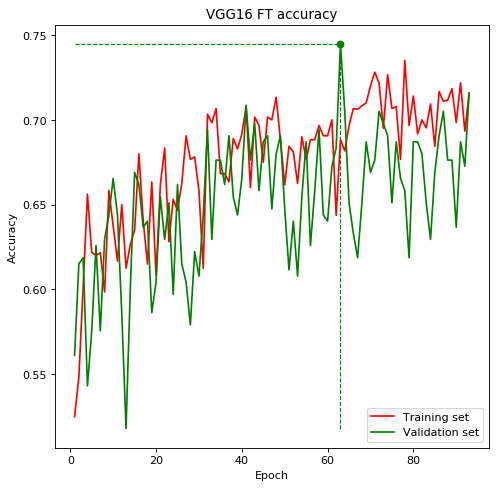

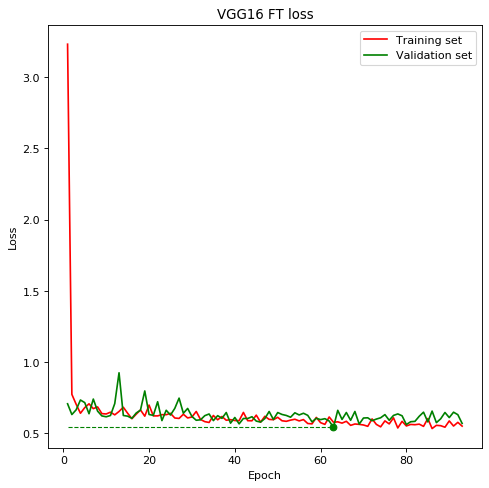

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [17]:
vgg16_mass_benign_or_malignant_best_Adadelta = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [18]:
# Train
history_vgg16_mass_benign_or_malignant_best_Adadelta = vgg16_mass_benign_or_malignant_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.5277 - recall: 0.4576
Epoch 00001: val_loss improved from inf to 1.30070, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 11s 2s/step - loss: 1.5241 - recall: 0.4600 - val_loss: 1.3007 - val_recall: 0.4568
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3710 - recall: 0.5042
Epoch 00002: val_loss improved from 1.30070 to 1.25097, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 12s 2s/step - loss: 1.3919 - recall: 0.5000 - val_loss: 1.2510 - val_recall: 0.5144
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4767 - recall: 0.4873
Epoch 00003: val_loss improved from 1.25097 to 1.02616, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5
5/5 [===

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3718 - recall: 0.4824
Epoch 00030: val_loss did not improve from 0.82596
5/5 [==============================] - 11s 2s/step - loss: 1.3552 - recall: 0.5031 - val_loss: 1.1177 - val_recall: 0.3885
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3795 - recall: 0.4629
Epoch 00031: val_loss did not improve from 0.82596
5/5 [==============================] - 11s 2s/step - loss: 1.4135 - recall: 0.4625 - val_loss: 1.0157 - val_recall: 0.4928
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3586 - recall: 0.4727
Epoch 00032: val_loss did not improve from 0.82596
5/5 [==============================] - 11s 2s/step - loss: 1.3762 - recall: 0.4672 - val_loss: 1.0260 - val_recall: 0.5216
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3311 - recall: 0.5059
Epoch 00033: val_loss did not improve from 0.82596
5/5 [==============================] - 11s 2s/step - loss: 

In [19]:
models.save_model(vgg16_mass_benign_or_malignant_best_Adadelta, '../model/vgg16_mass_benign_or_malignant_end_Adadelta.h5')

In [20]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adadelta.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adadelta.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adadelta.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Adadelta.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 49
Epoch [opt]: 19
Valid accuracy [end]: 0.4676
Valid accuracy [opt]: 0.5683
Test accuracy [end]:  0.4575
Test accuracy [opt]:  0.4314
Valid loss [end]: 1.0637
Valid loss [opt]: 0.8260
Test loss [end]:  1.3832
Test loss [opt]:  1.4814


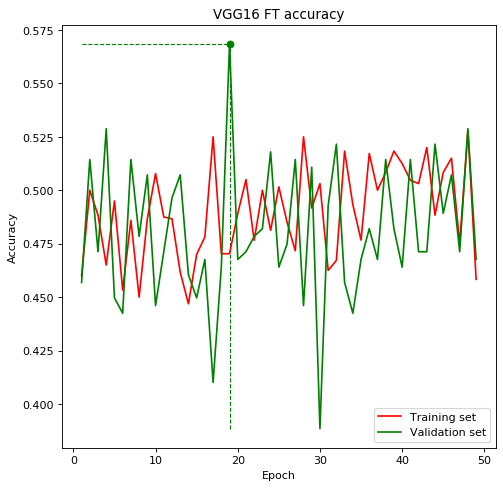

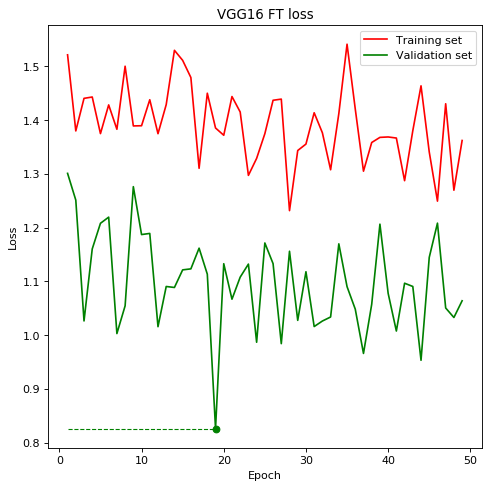

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [22]:
vgg16_mass_benign_or_malignant_best_Adagrad = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_vgg16_mass_benign_or_malignant_best_Adagrad = vgg16_mass_benign_or_malignant_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3107 - recall: 0.4941
Epoch 00001: val_loss improved from inf to 1.09540, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 11s 2s/step - loss: 1.3447 - recall: 0.4875 - val_loss: 1.0954 - val_recall: 0.4784
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1369 - recall: 0.5430
Epoch 00002: val_loss improved from 1.09540 to 0.98934, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 12s 2s/step - loss: 1.1433 - recall: 0.5422 - val_loss: 0.9893 - val_recall: 0.5540
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0995 - recall: 0.5293
Epoch 00003: val_loss improved from 0.98934 to 0.90870, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
5/5 [======

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9919 - recall: 0.5664
Epoch 00029: val_loss did not improve from 0.71636
5/5 [==============================] - 10s 2s/step - loss: 0.9833 - recall: 0.5562 - val_loss: 0.8242 - val_recall: 0.5432
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9378 - recall: 0.5605
Epoch 00030: val_loss did not improve from 0.71636
5/5 [==============================] - 11s 2s/step - loss: 0.9293 - recall: 0.5656 - val_loss: 0.7878 - val_recall: 0.5396
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7752 - recall: 0.6165
Epoch 00031: val_loss improved from 0.71636 to 0.68810, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 10s 2s/step - loss: 0.8062 - recall: 0.6100 - val_loss: 0.6881 - val_recall: 0.6223
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8982 - recall: 0.6165
Epoch 00032: val_loss did not imp

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8543 - recall: 0.5678
Epoch 00059: val_loss did not improve from 0.64383
5/5 [==============================] - 10s 2s/step - loss: 0.8622 - recall: 0.5617 - val_loss: 0.7512 - val_recall: 0.5863
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7573 - recall: 0.5801
Epoch 00060: val_loss did not improve from 0.64383
5/5 [==============================] - 10s 2s/step - loss: 0.7689 - recall: 0.5750 - val_loss: 0.6661 - val_recall: 0.5971
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7454 - recall: 0.6270
Epoch 00061: val_loss did not improve from 0.64383
5/5 [==============================] - 10s 2s/step - loss: 0.7590 - recall: 0.6062 - val_loss: 0.6725 - val_recall: 0.5935
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8107 - recall: 0.5938
Epoch 00062: val_loss did not improve from 0.64383
5/5 [==============================] - 10s 2s/step - loss: 

Epoch 89/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7458 - recall: 0.6191
Epoch 00089: val_loss did not improve from 0.62963
5/5 [==============================] - 10s 2s/step - loss: 0.7588 - recall: 0.6187 - val_loss: 0.6709 - val_recall: 0.6079
Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7587 - recall: 0.6250
Epoch 00090: val_loss did not improve from 0.62963
5/5 [==============================] - 9s 2s/step - loss: 0.7473 - recall: 0.6267 - val_loss: 0.6404 - val_recall: 0.6223
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7570 - recall: 0.6038
Epoch 00091: val_loss did not improve from 0.62963
5/5 [==============================] - 10s 2s/step - loss: 0.7835 - recall: 0.6067 - val_loss: 0.6711 - val_recall: 0.5863
Epoch 92/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7703 - recall: 0.6152
Epoch 00092: val_loss did not improve from 0.62963
5/5 [==============================] - 10s 2s/step - loss: 0

Epoch 149/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7128 - recall: 0.6094
Epoch 00149: val_loss did not improve from 0.57479
5/5 [==============================] - 11s 2s/step - loss: 0.7129 - recall: 0.6094 - val_loss: 0.6242 - val_recall: 0.6115
Epoch 150/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7524 - recall: 0.6059
Epoch 00150: val_loss did not improve from 0.57479
5/5 [==============================] - 10s 2s/step - loss: 0.7885 - recall: 0.6017 - val_loss: 0.5911 - val_recall: 0.6331
Epoch 151/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6959 - recall: 0.6271
Epoch 00151: val_loss did not improve from 0.57479
5/5 [==============================] - 10s 2s/step - loss: 0.7113 - recall: 0.6167 - val_loss: 0.6082 - val_recall: 0.6583
Epoch 152/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6800 - recall: 0.6328
Epoch 00152: val_loss did not improve from 0.57479
5/5 [==============================] - 10s 2s/step - lo

In [24]:
models.save_model(vgg16_mass_benign_or_malignant_best_Adagrad, '../model/vgg16_mass_benign_or_malignant_end_Adagrad.h5')

In [25]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adagrad.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adagrad.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adagrad.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Adagrad.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 174
Epoch [opt]: 144
Valid accuracy [end]: 0.6511
Valid accuracy [opt]: 0.6835
Test accuracy [end]:  0.6340
Test accuracy [opt]:  0.6438
Valid loss [end]: 0.6244
Valid loss [opt]: 0.5748
Test loss [end]:  0.7279
Test loss [opt]:  0.7389


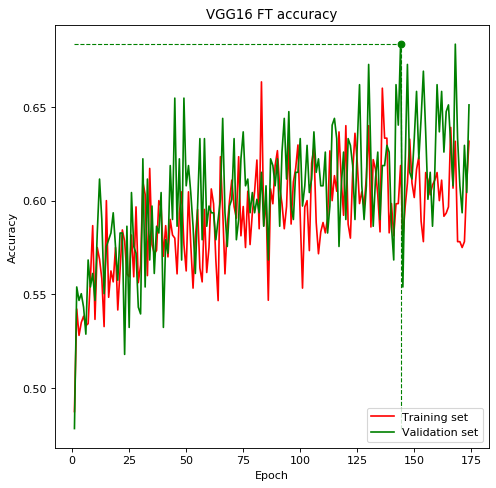

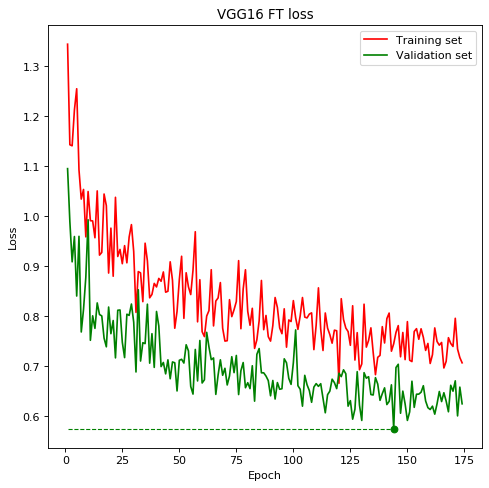

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [12]:
vgg16_mass_benign_or_malignant_best_Adamax = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [13]:
# Train
history_vgg16_mass_benign_or_malignant_best_Adamax = vgg16_mass_benign_or_malignant_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.5109 - recall: 0.5215
Epoch 00001: val_loss improved from inf to 0.92387, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 18s 4s/step - loss: 1.4092 - recall: 0.5333 - val_loss: 0.9239 - val_recall: 0.5863
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9988 - recall: 0.6094
Epoch 00002: val_loss improved from 0.92387 to 0.73624, saving model to ../model/vgg16_mass_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 11s 2s/step - loss: 1.0118 - recall: 0.5953 - val_loss: 0.7362 - val_recall: 0.6295
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9649 - recall: 0.5254
Epoch 00003: val_loss improved from 0.73624 to 0.73405, saving mo

Epoch 58/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6452 - recall: 0.6523
Epoch 00058: val_loss did not improve from 0.57985
5/5 [==============================] - 10s 2s/step - loss: 0.6578 - recall: 0.6516 - val_loss: 0.5918 - val_recall: 0.6619
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6630 - recall: 0.6335
Epoch 00059: val_loss did not improve from 0.57985
5/5 [==============================] - 11s 2s/step - loss: 0.6491 - recall: 0.6483 - val_loss: 0.6111 - val_recall: 0.6331
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6738 - recall: 0.6348
Epoch 00060: val_loss did not improve from 0.57985
5/5 [==============================] - 10s 2s/step - loss: 0.6591 - recall: 0.6422 - val_loss: 0.6078 - val_recall: 0.6906
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6329 - recall: 0.6680
Epoch 00061: val_loss did not improve from 0.57985
5/5 [==============================] - 11s 2s/step - loss: 

4/5 [=======================>......] - ETA: 1s - loss: 0.6005 - recall: 0.6970
Epoch 00118: val_loss did not improve from 0.55597
5/5 [==============================] - 10s 2s/step - loss: 0.5979 - recall: 0.6983 - val_loss: 0.6465 - val_recall: 0.6367
Epoch 119/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6167 - recall: 0.6836
Epoch 00119: val_loss did not improve from 0.55597
5/5 [==============================] - 10s 2s/step - loss: 0.6081 - recall: 0.6906 - val_loss: 0.6350 - val_recall: 0.6511
Epoch 120/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6315 - recall: 0.6621
Epoch 00120: val_loss did not improve from 0.55597
5/5 [==============================] - 11s 2s/step - loss: 0.6254 - recall: 0.6683 - val_loss: 0.6041 - val_recall: 0.6619
Epoch 121/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6248 - recall: 0.6525
Epoch 00121: val_loss did not improve from 0.55597
5/5 [==============================] - 10s 2s/step - loss: 0.6162 - r

In [14]:
models.save_model(vgg16_mass_benign_or_malignant_best_Adamax, '../model/vgg16_mass_benign_or_malignant_end_Adamax.h5')

In [15]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adamax.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adamax.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Adamax.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Adamax.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 142
Epoch [opt]: 112
Valid accuracy [end]: 0.6475
Valid accuracy [opt]: 0.6691
Test accuracy [end]:  0.6765
Test accuracy [opt]:  0.6699
Valid loss [end]: 0.5887
Valid loss [opt]: 0.5560
Test loss [end]:  0.6254
Test loss [opt]:  0.6328


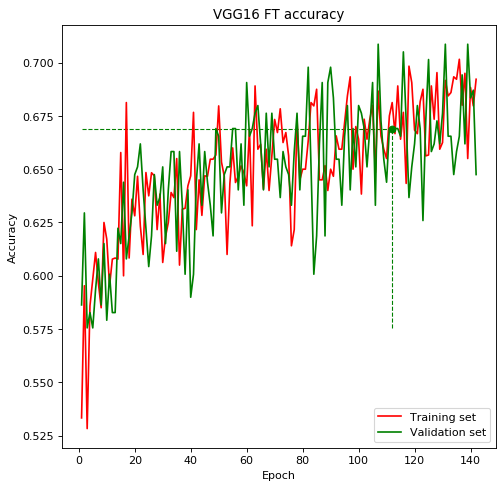

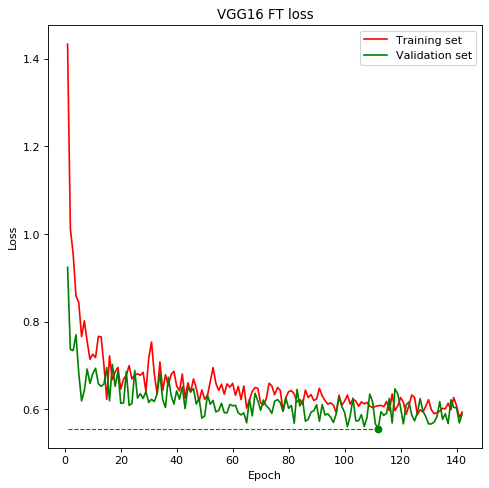

In [16]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [17]:
vgg16_mass_benign_or_malignant_best_Nadam = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [18]:
# Train
history_vgg16_mass_benign_or_malignant_best_Nadam = vgg16_mass_benign_or_malignant_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 2.1606 - recall: 0.5039
Epoch 00001: val_loss improved from inf to 0.72182, saving model to ../model/vgg16_mass_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 11s 2s/step - loss: 1.9343 - recall: 0.5156 - val_loss: 0.7218 - val_recall: 0.6439
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9481 - recall: 0.6016
Epoch 00002: val_loss did not improve from 0.72182
5/5 [==============================] - 11s 2s/step - loss: 0.9190 - recall: 0.5984 - val_loss: 0.7907 - val_recall: 0.6259
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8833 - recall: 0.6094
Epoch 00003: val_loss improved from 0.72182 to 0.64724, saving model to ../model/vgg16_mass_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 12s 2s/step - loss: 0.8455 - recall: 0.6187 - val_los

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6171 - recall: 0.6928
Epoch 00030: val_loss did not improve from 0.58433
5/5 [==============================] - 10s 2s/step - loss: 0.6155 - recall: 0.6950 - val_loss: 0.6226 - val_recall: 0.6655
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5832 - recall: 0.7012
Epoch 00031: val_loss improved from 0.58433 to 0.57750, saving model to ../model/vgg16_mass_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5942 - recall: 0.6922 - val_loss: 0.5775 - val_recall: 0.6511
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6245 - recall: 0.6504
Epoch 00032: val_loss did not improve from 0.57750
5/5 [==============================] - 10s 2s/step - loss: 0.6266 - recall: 0.6533 - val_loss: 0.6096 - val_recall: 0.6439
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6101 - recall: 0.6621
Epoch 00033: val_loss did not impro

4/5 [=======================>......] - ETA: 1s - loss: 0.5873 - recall: 0.7090
Epoch 00090: val_loss did not improve from 0.55935
5/5 [==============================] - 11s 2s/step - loss: 0.5850 - recall: 0.6969 - val_loss: 0.5798 - val_recall: 0.7014
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5691 - recall: 0.6914
Epoch 00091: val_loss did not improve from 0.55935
5/5 [==============================] - 11s 2s/step - loss: 0.5793 - recall: 0.6781 - val_loss: 0.5987 - val_recall: 0.6547
Epoch 92/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5408 - recall: 0.7246
Epoch 00092: val_loss did not improve from 0.55935
5/5 [==============================] - 11s 2s/step - loss: 0.5584 - recall: 0.7203 - val_loss: 0.6251 - val_recall: 0.6223
Epoch 93/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5342 - recall: 0.7305
Epoch 00093: val_loss did not improve from 0.55935
5/5 [==============================] - 11s 2s/step - loss: 0.5424 - reca

In [19]:
models.save_model(vgg16_mass_benign_or_malignant_best_Nadam, '../model/vgg16_mass_benign_or_malignant_end_Nadam.h5')

In [20]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Nadam.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Nadam.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Nadam.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Nadam.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 102
Epoch [opt]: 72
Valid accuracy [end]: 0.6547
Valid accuracy [opt]: 0.6691
Test accuracy [end]:  0.6438
Test accuracy [opt]:  0.6732
Valid loss [end]: 0.6072
Valid loss [opt]: 0.5594
Test loss [end]:  0.6475
Test loss [opt]:  0.6299


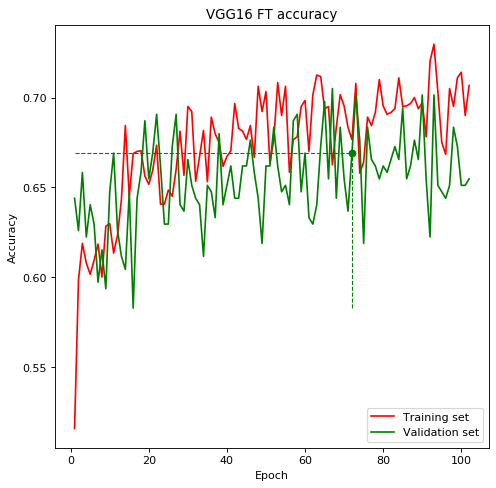

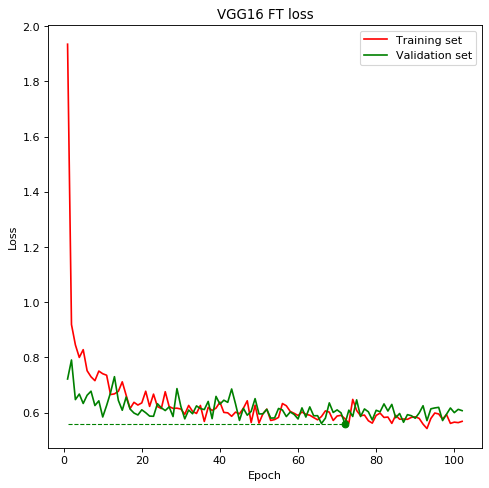

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Ftrl

In [13]:
vgg16_mass_benign_or_malignant_best_Ftrl = create_vgg16(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg16_mass_benign_or_malignant_best_Ftrl.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg16_mass_benign_or_malignant_best_Ftrl.compile(optimizer=optimizers.Ftrl(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg16_mass_benign_or_malignant_best_Ftrl = vgg16_mass_benign_or_malignant_best_Ftrl.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 0.7982 - recall: 0.4844
Epoch 00001: val_loss improved from inf to 0.69315, saving model to ../model/vgg16_mass_benign_or_malignant_best_Ftrl.h5
5/5 [==============================] - 14s 3s/step - loss: 0.7772 - recall: 0.4859 - val_loss: 0.6931 - val_recall: 0.4532
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6931 - recall: 0.5117
Epoch 00002: val_loss did not improve from 0.69315
5/5 [==============================] - 10s 2s/step - loss: 0.6931 - recall: 0.5219 - val_loss: 0.6932 - val_recall: 0.5144
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6931 - recall: 0.5371
Epoch 00003: val_loss did not improve from 0.69315
5/5 [==============================] - 11s 2s/step - loss: 0.6931 - recall: 0.5437 - val_los

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6930 - recall: 0.5487
Epoch 00030: val_loss did not improve from 0.69315
5/5 [==============================] - 10s 2s/step - loss: 0.6930 - recall: 0.5433 - val_loss: 0.6933 - val_recall: 0.4856
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6930 - recall: 0.5530
Epoch 00031: val_loss did not improve from 0.69315
5/5 [==============================] - 10s 2s/step - loss: 0.6930 - recall: 0.5433 - val_loss: 0.6933 - val_recall: 0.4856
Epoch 00031: early stopping


In [16]:
models.save_model(vgg16_mass_benign_or_malignant_best_Ftrl, '../model/vgg16_mass_benign_or_malignant_end_Ftrl.h5')

In [17]:
tra_loss_fe = history_vgg16_mass_benign_or_malignant_best_Ftrl.history['loss']
tra_acc_fe = history_vgg16_mass_benign_or_malignant_best_Ftrl.history['recall']
val_loss_fe = history_vgg16_mass_benign_or_malignant_best_Ftrl.history['val_loss']
val_acc_fe = history_vgg16_mass_benign_or_malignant_best_Ftrl.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg16_mass_benign_or_malignant = models.load_model('../model/vgg16_mass_benign_or_malignant_best_Ftrl.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_best_Ftrl.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG16 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 benign or malignant

Epoch [end]: 31
Epoch [opt]: 1
Valid accuracy [end]: 0.4856
Valid accuracy [opt]: 0.4532
Test accuracy [end]:  0.5882
Test accuracy [opt]:  0.4902
Valid loss [end]: 0.6933
Valid loss [opt]: 0.6931
Test loss [end]:  0.6929
Test loss [opt]:  0.6931


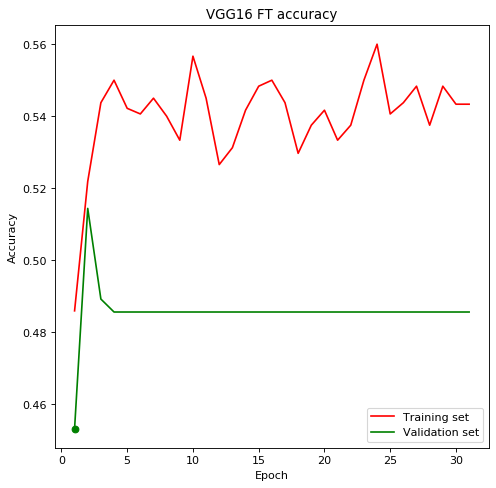

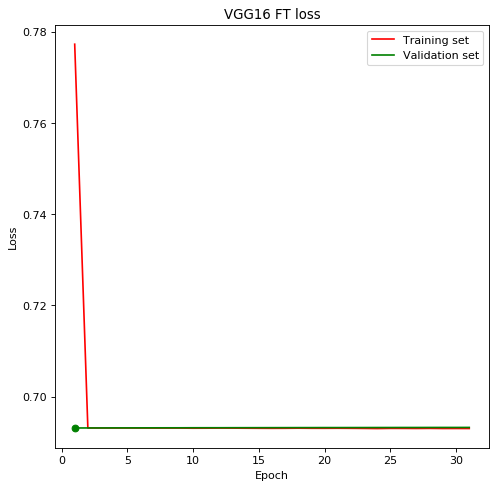

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [18]:
vgg16_mass_benign_or_malignant_fine_RMSprop = models.load_model('../model/vgg16_mass_benign_or_malignant_best_RMSprop.h5')

for layer in vgg16_mass_benign_or_malignant_fine_RMSprop.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_mass_benign_or_malignant_fine_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_mass_benign_or_malignant_fine_RMSprop.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [19]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [20]:
history_fit = vgg16_mass_benign_or_malignant_fine_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6462 - recall: 0.6582
Epoch 00001: val_loss improved from inf to 0.64340, saving model to ../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6365 - recall: 0.6703 - val_loss: 0.6434 - val_recall: 0.6763
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5676 - recall: 0.6970
Epoch 00002: val_loss improved from 0.64340 to 0.63946, saving model to ../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5598 - recall: 0.7017 - val_loss: 0.6395 - val_recall: 0.6727
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5827 - recall: 0.6875
Epoch 00003: val_loss improved from 0.63946 to 0.61788, saving model to ../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5224 - recall: 0.7436
Epoch 00029: val_loss did not improve from 0.52227
5/5 [==============================] - 10s 2s/step - loss: 0.5361 - recall: 0.7417 - val_loss: 0.5507 - val_recall: 0.6835
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5154 - recall: 0.7267
Epoch 00030: val_loss did not improve from 0.52227
5/5 [==============================] - 10s 2s/step - loss: 0.5329 - recall: 0.7200 - val_loss: 0.5985 - val_recall: 0.6942
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4941 - recall: 0.7712
Epoch 00031: val_loss did not improve from 0.52227
5/5 [==============================] - 10s 2s/step - loss: 0.5101 - recall: 0.7533 - val_loss: 0.5299 - val_recall: 0.7410
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5253 - recall: 0.7383
Epoch 00032: val_loss did not improve from 0.52227
5/5 [==============================] - 10s 2s/step - loss: 

In [21]:
models.save_model(vgg16_mass_benign_or_malignant_fine_RMSprop, '../model/vgg16_mass_benign_or_malignant_fine_RMSprop_end.h5')

In [22]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_mass_benign_or_malignant_fine_RMSprop = models.load_model('../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 55
Epoch [opt]: 25
Valid accuracy [end]: 0.6906
Valid accuracy [opt]: 0.7014
Test accuracy [end]:  0.6667
Test accuracy [opt]:  0.7092
Valid loss [end]: 0.6349
Valid loss [opt]: 0.5223
Test loss [end]:  0.6182
Test loss [opt]:  0.6038


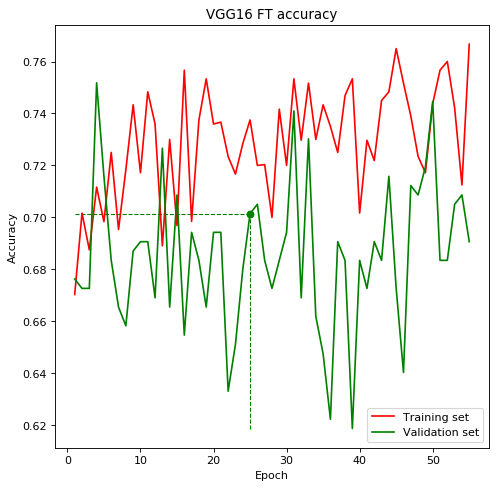

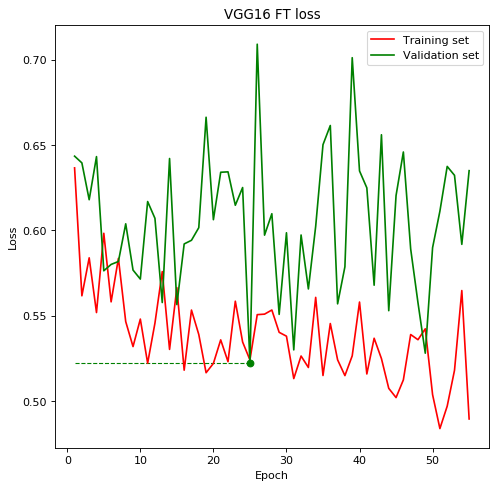

In [23]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [24]:
vgg16_mass_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best.h5')

for layer in vgg16_mass_benign_or_malignant_fine_RMSprop2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_mass_benign_or_malignant_fine_RMSprop2.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_mass_benign_or_malignant_fine_RMSprop2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [25]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [26]:
history_fit = vgg16_mass_benign_or_malignant_fine_RMSprop2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7331 - recall: 0.6589
Epoch 00001: val_loss improved from inf to 0.60239, saving model to ../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best2.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6991 - recall: 0.6750 - val_loss: 0.6024 - val_recall: 0.6655
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5941 - recall: 0.6973
Epoch 00002: val_loss did not improve from 0.60239
5/5 [==============================] - 10s 2s/step - loss: 0.6078 - recall: 0.6750 - val_loss: 0.6414 - val_recall: 0.6079
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5662 - recall: 0.6875
Epoch 00003: val_loss did not improve from 0.60239
5/5 [==============================] - 10s 2s/step - loss: 0.5564 - recall: 0.7031 - val_loss: 0.6510 - val_recall: 0.6727
Epoch 4/300
4/5 [===================

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5011 - recall: 0.7394
Epoch 00030: val_loss did not improve from 0.53247
5/5 [==============================] - 10s 2s/step - loss: 0.5232 - recall: 0.7250 - val_loss: 0.6454 - val_recall: 0.6151
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5146 - recall: 0.7394
Epoch 00031: val_loss did not improve from 0.53247
5/5 [==============================] - 10s 2s/step - loss: 0.5206 - recall: 0.7417 - val_loss: 0.5668 - val_recall: 0.7050
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4658 - recall: 0.7987
Epoch 00032: val_loss did not improve from 0.53247
5/5 [==============================] - 10s 2s/step - loss: 0.4812 - recall: 0.7850 - val_loss: 0.6593 - val_recall: 0.6547
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4898 - recall: 0.7648
Epoch 00033: val_loss did not improve from 0.53247
5/5 [==============================] - 10s 2s/step - loss: 

4/5 [=======================>......] - ETA: 1s - loss: 0.4863 - recall: 0.7733
Epoch 00060: val_loss did not improve from 0.52510
5/5 [==============================] - 10s 2s/step - loss: 0.4758 - recall: 0.7783 - val_loss: 0.5504 - val_recall: 0.6906
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4805 - recall: 0.7598
Epoch 00061: val_loss did not improve from 0.52510
5/5 [==============================] - 10s 2s/step - loss: 0.4695 - recall: 0.7583 - val_loss: 0.6921 - val_recall: 0.6043
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5278 - recall: 0.7324
Epoch 00062: val_loss did not improve from 0.52510
5/5 [==============================] - 11s 2s/step - loss: 0.5194 - recall: 0.7359 - val_loss: 0.5941 - val_recall: 0.6978
Epoch 63/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4665 - recall: 0.7656
Epoch 00063: val_loss did not improve from 0.52510
5/5 [==============================] - 11s 2s/step - loss: 0.4717 - reca

In [27]:
models.save_model(vgg16_mass_benign_or_malignant_fine_RMSprop2, '../model/vgg16_mass_benign_or_malignant_fine_RMSprop_end2.h5')

In [29]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_mass_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best2.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 83
Epoch [opt]: 53
Valid accuracy [end]: 0.6727
Valid accuracy [opt]: 0.7302
Test accuracy [end]:  0.7026
Test accuracy [opt]:  0.6275
Valid loss [end]: 0.5818
Valid loss [opt]: 0.5251
Test loss [end]:  0.6054
Test loss [opt]:  0.7963


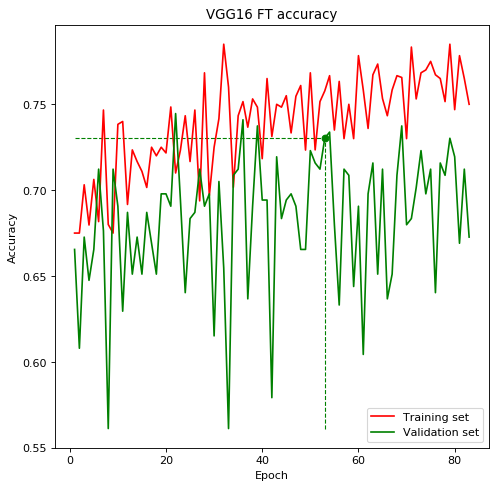

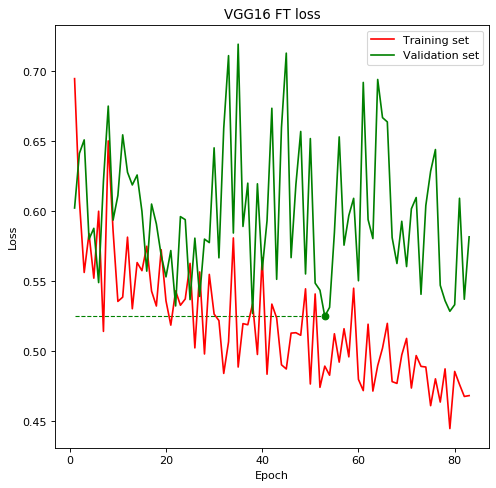

In [30]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [31]:
vgg16_mass_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best2.h5')

for layer in vgg16_mass_benign_or_malignant_fine_RMSprop2.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_mass_benign_or_malignant_fine_RMSprop3.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg16_mass_benign_or_malignant_fine_RMSprop3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [32]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [33]:
history_fit = vgg16_mass_benign_or_malignant_fine_RMSprop3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6927 - recall: 0.6621
Epoch 00001: val_loss improved from inf to 0.65379, saving model to ../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6525 - recall: 0.6812 - val_loss: 0.6538 - val_recall: 0.7122
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5125 - recall: 0.7521
Epoch 00002: val_loss improved from 0.65379 to 0.64871, saving model to ../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 10s 2s/step - loss: 0.5072 - recall: 0.7567 - val_loss: 0.6487 - val_recall: 0.6942
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4763 - recall: 0.7793
Epoch 00003: val_loss did not improve from 0.64871
5/5 [==============================] - 10s 2s/step - loss: 0.4645 - recall: 

4/5 [=======================>......] - ETA: 1s - loss: 0.4753 - recall: 0.7891
Epoch 00030: val_loss did not improve from 0.52110
5/5 [==============================] - 10s 2s/step - loss: 0.4759 - recall: 0.7828 - val_loss: 0.5352 - val_recall: 0.7194
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4291 - recall: 0.7945
Epoch 00031: val_loss did not improve from 0.52110
5/5 [==============================] - 10s 2s/step - loss: 0.4309 - recall: 0.7883 - val_loss: 0.5674 - val_recall: 0.7302
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5207 - recall: 0.7140
Epoch 00032: val_loss did not improve from 0.52110
5/5 [==============================] - 10s 2s/step - loss: 0.5127 - recall: 0.7250 - val_loss: 0.5822 - val_recall: 0.7086
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4635 - recall: 0.7773
Epoch 00033: val_loss did not improve from 0.52110
5/5 [==============================] - 10s 2s/step - loss: 0.4632 - reca

In [34]:
models.save_model(vgg16_mass_benign_or_malignant_fine_RMSprop3, '../model/vgg16_mass_benign_or_malignant_fine_RMSprop_end3.h5')

In [35]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_mass_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/vgg16_mass_benign_or_malignant_fine_RMSprop_best3.h5')
test_loss_fe, test_acc_fe = vgg16_mass_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_mass_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 34
Epoch [opt]: 4
Valid accuracy [end]: 0.7302
Valid accuracy [opt]: 0.7446
Test accuracy [end]:  0.6569
Test accuracy [opt]:  0.7190
Valid loss [end]: 0.5489
Valid loss [opt]: 0.5211
Test loss [end]:  0.6383
Test loss [opt]:  0.6288


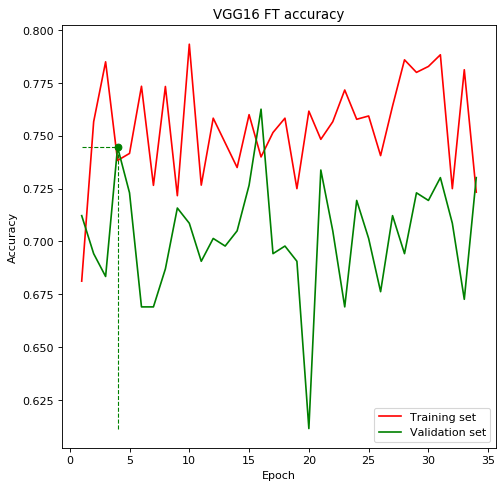

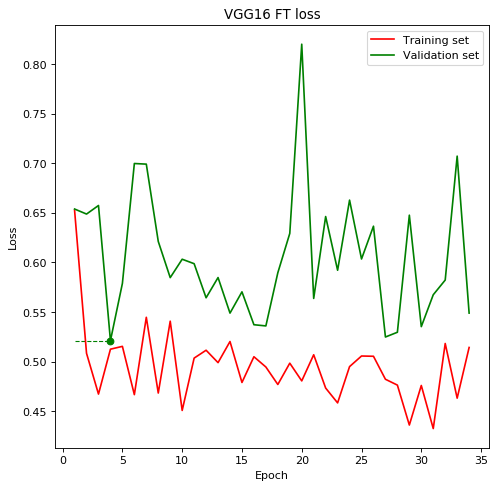

In [36]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();